# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.

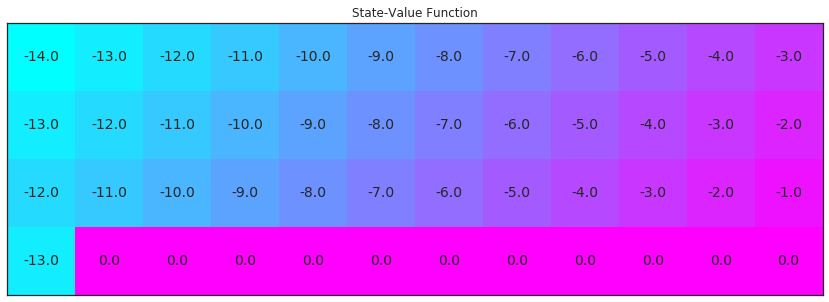

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [5]:

# this function will return a list where each index corresponds to an action (0 - 3) and the value
# at each index is the probability of that action being chosen.
# the set of equations used to populate the value at each index can be found in the SARSA writeup under
# "Expected SARSA" (equations in blue).

# env       - the cliff-walking environment variable
# state     - the current state
# i_episode - the current episode
# eps       - the value of epsilon

def epsilon_greedy_probs(env, Q_state, i_episode, eps=None):
    
    epsilon = 0.0
    
    if eps is not None:
        
        epsilon = eps
        
    else:
        
        # if no value of epsilon is given, obtain a value. 
        # the population of this value adheres to the rule of 'exploration early on'.
        # that is, for early time-steps, the agent trusts the Q-Table less. Conversely,
        # for later time-steps (that is to say, greater values of i_episode 
        # when the agent better understands the environment), the agent favors the Q-Table.
        
        epsilon = 1.0 / i_episode
    
    # initialize a list of length env.nA and populate each index with base probability, epsilon / env.nA.
    # taken from the equations in blue under "SARSA" write-up.
    state_policy = np.ones(env.nA) * epsilon / env.nA
    
    # obtain the index of the action corresponding to the greatest expected reward for this particular state.
    greedy_action = np.argmax(Q_state)
    
    # for the action in this state that has the greatest expected reward, increase its probability.
    # according to the set of equations in blue under "SARSA" write-up.
    state_policy[greedy_action] = 1 - epsilon + ( epsilon / env.nA )
    
    # return the action policy for this state
    return state_policy
    

In [6]:

# given a current state-action pair, next state-action pair, and the reward for the current state-action pair,
# update Q[state][action].

# This function implements the SARSA Temporal Difference estimate of Q, which is the action-policy
# for this cliff-walking environment

def updateQ(Q_sa, Q_nsa, reward, alpha, gamma):
    
    # the equation for this is given in the "SARSA" write-up, under the SARSA algorithm
    return Q_sa + (alpha * (reward + (gamma * Q_nsa) - Q_sa))


In [7]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    
    # initialize performance monitors:
    # the "timer" for which to update performance metrics
    plot_every = 100
    # container for the scores of each episode
    temp_scores = deque(maxlen=plot_every)
    # container to hold the mean of scores up to a certain episode count
    scores = deque(maxlen=num_episodes)
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # begin the episode. reset() will return the initial state (state-36)
        state = env.reset()
        
        # initialize score for this episode
        score = 0.0
        
        # obtain the epsilon-greedy action probabilities corresponding to this state
        eps_action_policy = epsilon_greedy_probs(env, Q[state], i_episode)
        
        # from the action policy, choose an action A
        action = np.random.choice(np.arange(env.nA), p=eps_action_policy)
        
        # iterate through a defined number of time-steps (limit)
        for t_step in np.arange(300):
            
            # given the current state and action, observe the reward (R) and next state (S')
            next_state, reward, done, info = env.step(action)
            
            # update running score for this episode
            score += reward
            
            # check for new state == goal state
            if not done:
                
                # obtain a new epsilon greedy action policy for state S'
                eps_action_policy = epsilon_greedy_probs(env, Q[next_state], i_episode)
                
                # from the action policy, choose an action A'
                next_action = np.random.choice(np.arange(env.nA), p=eps_action_policy)
                
                # CRITICAL POINT. SARSA algorithm will update the Q-Table (s0, a0)
                Q[state][action] = updateQ(Q[state][action], Q[next_state][next_action], reward, alpha, gamma)
                
                # set the current state to the next state
                state = next_state
                
                # set the current action to the next action
                action = next_action
                
            else:
                
                # Terminal state. finalze this Q-Table entry.
                Q[state][action] = updateQ(Q[state][action], 0, reward, alpha, gamma)
                
                # set the score for this episode
                temp_scores.append(score)
                
                # terminate this episode.
                break
        
        # plot the average score up to this point
        if i_episode % plot_every == 0:
            
            scores.append(np.mean(temp_scores))

    # plot performance of SARSA
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
                        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  


Episode 5000/5000

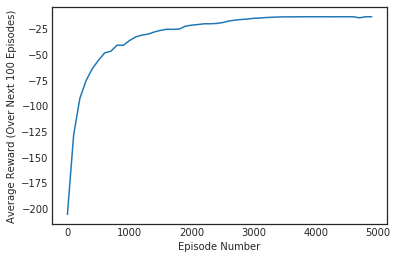

Best Average Reward over 100 Episodes:  -13.0

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  0  2  1  1  0  2  2  1  2  1]
 [ 0  1  1  1  1  1  0  1  0  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


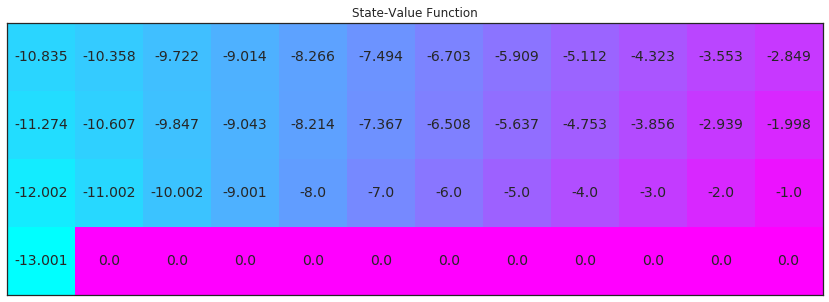

In [8]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [9]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    
    # initialize performance monitors:
    # the "timer" for which to update performance metrics
    plot_every = 100
    # container for the scores of each episode
    temp_scores = deque(maxlen=plot_every)
    # container to hold the mean of scores up to a certain episode count
    scores = deque(maxlen=num_episodes)
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # begin the episode. reset() will return the initial state (state-36)
        state = env.reset()
        
        # initialize score for this episode
        score = 0.0
                
        # iterate through a defined number of time-steps (limit)
        while True:
            
            # obtain the epsilon-greedy action probabilities corresponding to this state
            eps_action_policy = epsilon_greedy_probs(env, Q[state], i_episode)
        
            # from the action policy, choose an action A
            action = np.random.choice(np.arange(env.nA), p=eps_action_policy)
            
            # given the current state and action, observe the reward (R) and next state (S')
            next_state, reward, done, info = env.step(action)
            
            # update running score for this episode
            score += reward
            
            # update the Q-Table for the current state using this Temporal Difference approach
            # which is to pass in the maximum expected value of all possible actions for this state.
            Q[state][action] = updateQ(Q[state][action], np.max(Q[next_state]), reward, alpha, gamma)
            
            # set the current state to the next state
            state = next_state
            
            if done:
                
                # set the score for this episode
                temp_scores.append(score)
                
                # terminate this episode.
                break
                
                            
        # plot the average score up to this point
        if i_episode % plot_every == 0:
            
            scores.append(np.mean(temp_scores))

    # plot performance of SARSA
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
                        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

Episode 5000/5000

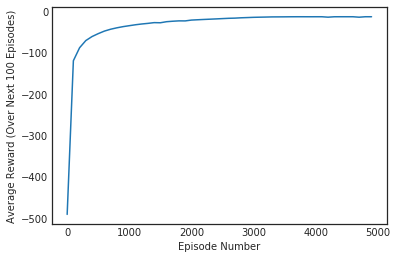

Best Average Reward over 100 Episodes:  -13.0

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  1  1  1  1  0  1  2  1  1  0]
 [ 1  2  3  1  1  1  0  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


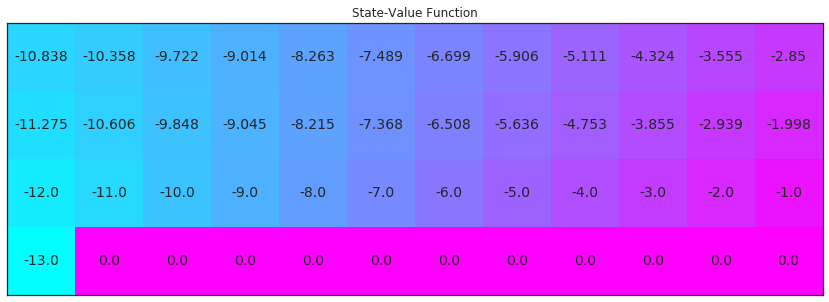

In [10]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [11]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    
    # initialize performance monitors:
    # the "timer" for which to update performance metrics
    plot_every = 100
    # container for the scores of each episode
    temp_scores = deque(maxlen=plot_every)
    # container to hold the mean of scores up to a certain episode count
    scores = deque(maxlen=num_episodes)
    
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # begin the episode. reset() will return the initial state (state-36)
        state = env.reset()
        
        # initialize score for this episode
        score = 0.0
                
        # obtain the epsilon-greedy action probabilities corresponding to this state
        eps_action_policy = epsilon_greedy_probs(env, Q[state], i_episode, 0.005)
        
        while True:                    
        
            # from the action policy, choose an action A
            action = np.random.choice(np.arange(env.nA), p=eps_action_policy)
            
            # given the current state and action, observe the reward (R) and next state (S')
            next_state, reward, done, info = env.step(action)
            
            # update running score for this episode
            score += reward
            
            # obtain the epsilon-greedy policy of this new state
            eps_action_policy = epsilon_greedy_probs(env, Q[next_state], i_episode, 0.005)
            
            # obtain expected value of this new state
            expected_value = np.dot(Q[next_state], eps_action_policy)
                                    
            # update the Q-Table entry for Q[state][action] using the expected reward of the next state
            Q[state][action] = updateQ(Q[state][action], expected_value, reward, alpha, gamma)
            
            # set the current state to the next state
            state = next_state
            
            if done:
                
                # set the score for this episode
                temp_scores.append(score)
                
                # terminate this episode.
                break
                
                            
        # plot the average score up to this point
        if i_episode % plot_every == 0:
            
            scores.append(np.mean(temp_scores))

    # plot performance of SARSA
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
                        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Episode 10000/10000

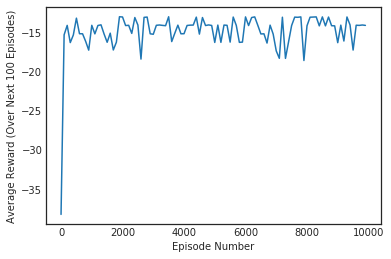

Best Average Reward over 100 Episodes:  -13.02

Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  0  1  1  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


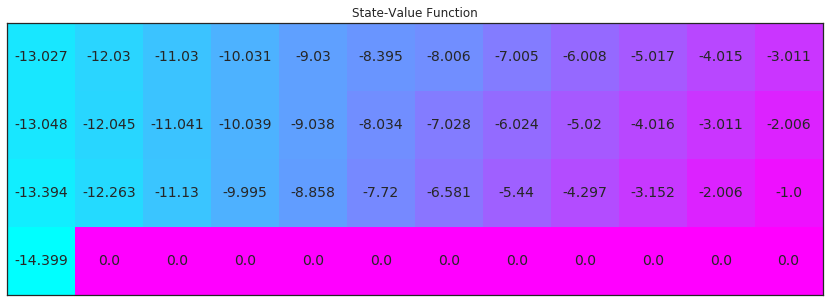

In [12]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])